In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv1D, Conv1DTranspose, Dropout
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [2]:
master_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'
small_noise_url_suffix = 'artificialNoAnomaly/art_daily_small_noise.csv'
small_noise_url = master_url + small_noise_url_suffix
df_small_noise = pd.read_csv(small_noise_url, parse_dates=True, index_col='timestamp')
df_small_noise

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120
...,...
2014-04-14 23:35:00,20.211195
2014-04-14 23:40:00,20.531041
2014-04-14 23:45:00,19.032127


In [8]:
daily_jumpsup_url_suffix = 'artificialWithAnomaly/art_daily_jumpsup.csv'
daily_jumpsup_url = master_url + daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(daily_jumpsup_url, parse_dates=True, index_col='timestamp')
df_daily_jumpsup

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739
...,...
2014-04-14 23:35:00,18.074649
2014-04-14 23:40:00,21.002014
2014-04-14 23:45:00,20.566713


<Axes: xlabel='timestamp'>

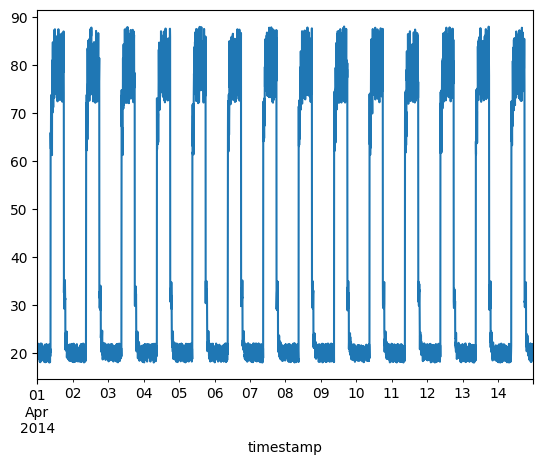

In [10]:
df_small_noise.plot(legend=False)

<Axes: xlabel='timestamp'>

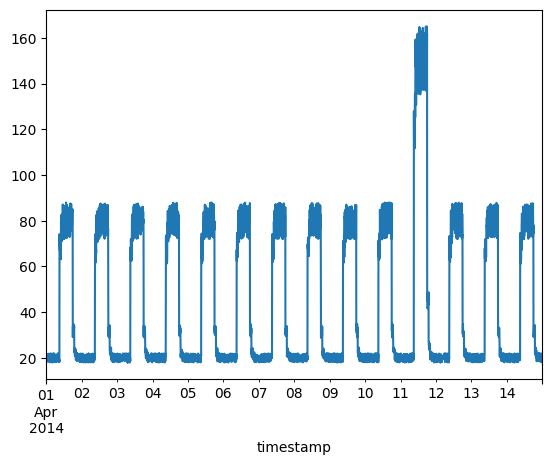

In [12]:
df_daily_jumpsup.plot(legend=False)

In [13]:
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
df_training_value

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173
...,...
2014-04-14 23:35:00,-0.791647
2014-04-14 23:40:00,-0.780255
2014-04-14 23:45:00,-0.833640


In [18]:
TIME_STEPS = 24 * 60 // 5 # 24h * 60min / 5min
TIME_STEPS # 288 timesteps per day

288

In [30]:
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i:(i + time_steps)])
    return np.stack(output)

In [32]:
X_train = create_sequences(df_training_value.values)
X_train.shape

(3745, 288, 1)

In [34]:
model = keras.Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(filters=32, kernel_size=7, padding='same', strides=2, activation='relu'),
    Dropout(rate=0.2),
    Conv1D(filters=16, kernel_size=7, padding='same', strides=2, activation='relu'),
    Dropout(rate=0.2),
    Conv1DTranspose(filters=16, kernel_size=7, padding='same', strides=2, activation='relu'),
    Conv1DTranspose(filters=32, kernel_size=7, padding='same', strides=2, activation='relu'),
    Conv1DTranspose(filters=1, kernel_size=1, padding='same'),
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='mse')

2023-07-19 05:26:20.509784: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6638 MB memory:  -> device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:3f:00.0, compute capability: 7.5


In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 dropout_1 (Dropout)         (None, 72, 16)            0         
                                                                 
 conv1d_transpose (Conv1DTr  (None, 144, 16)           1808      
 anspose)                                                        
                                                                 
 conv1d_transpose_1 (Conv1D  (None, 288, 32)           3616      
 Transpose)                                             

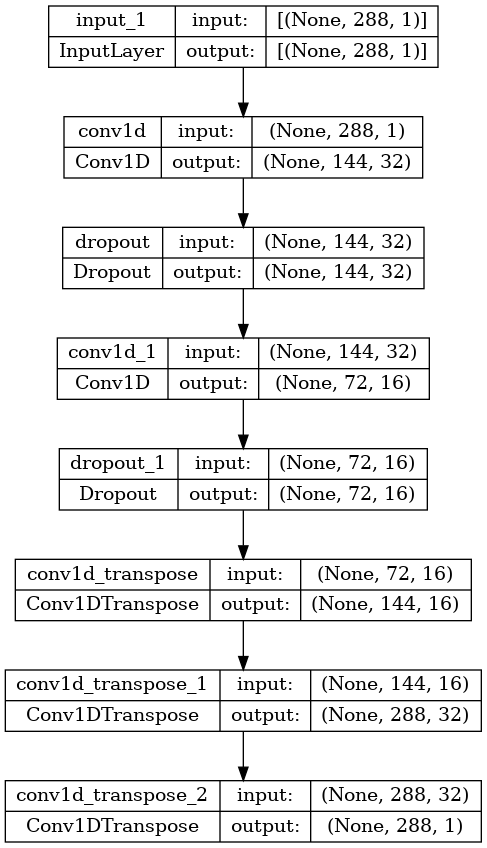

In [37]:
plot_model(model, show_shapes=True)

In [38]:
history = model.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')]
)

Epoch 1/50


2023-07-19 05:42:41.639861: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-19 05:42:42.948065: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x560be707b460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-19 05:42:42.948153: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): GeForce RTX 2070 SUPER, Compute Capability 7.5
2023-07-19 05:42:42.962332: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-19 05:42:43.142383: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


27/27 [==============================] - 6s 28ms/step - loss: 0.5170 - val_loss: 0.1051
Epoch 2/50
27/27 [==============================] - 0s 11ms/step - loss: 0.0789 - val_loss: 0.0426
Epoch 3/50
27/27 [==============================] - 0s 10ms/step - loss: 0.0571 - val_loss: 0.0362
Epoch 4/50
27/27 [==============================] - 0s 10ms/step - loss: 0.0480 - val_loss: 0.0296
Epoch 5/50
27/27 [==============================] - 0s 9ms/step - loss: 0.0413 - val_loss: 0.0256
Epoch 6/50
27/27 [==============================] - 0s 10ms/step - loss: 0.0368 - val_loss: 0.0230
Epoch 7/50
27/27 [==============================] - 0s 11ms/step - loss: 0.0337 - val_loss: 0.0223
Epoch 8/50
27/27 [==============================] - 0s 10ms/step - loss: 0.0313 - val_loss: 0.0207
Epoch 9/50
27/27 [==============================] - 0s 10ms/step - loss: 0.0293 - val_loss: 0.0206
Epoch 10/50
27/27 [==============================] - 0s 10ms/step - loss: 0.0276 - val_loss: 0.0214
Epoch 11/50
27/27 [==

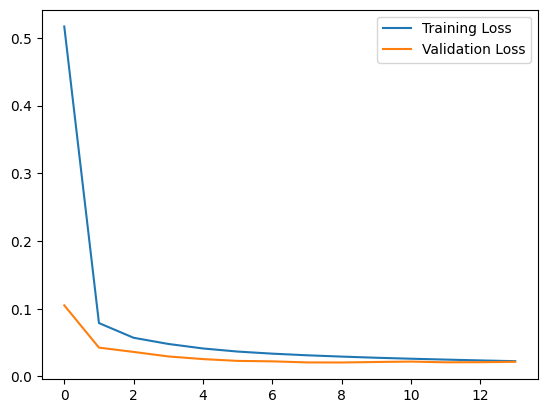

In [39]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

In [40]:
X_train.shape

(3745, 288, 1)

In [41]:
X_train_pred = model.predict(X_train)
train_mae = np.mean(np.absolute(X_train - X_train_pred), axis=1)
train_mae.shape

118/118 [==============================] - 1s 3ms/step


(3745, 1)

Text(0, 0.5, 'Number of samples')

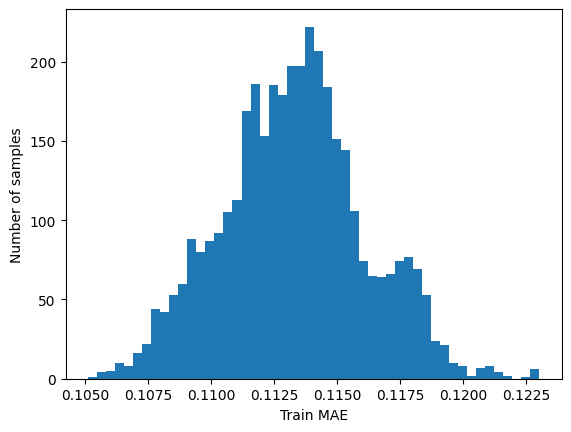

In [42]:
plt.hist(train_mae, bins=50)
plt.xlabel('Train MAE')
plt.ylabel('Number of samples')

In [43]:
threshold = np.max(train_mae)
threshold

0.1230133389112853

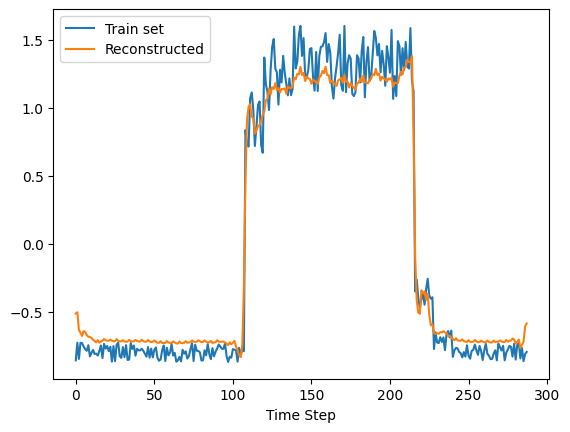

In [44]:
plt.plot(X_train[0], label='Train set')
plt.plot(X_train_pred[0], label='Reconstructed')
plt.xlabel('Time Step')
plt.legend()

In [45]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
df_test_value

,value
timestamp,
2014-04-01 00:00:00,-0.807672
2014-04-01 00:05:00,-0.781331
2014-04-01 00:10:00,-0.800535
2014-04-01 00:15:00,-0.746091
2014-04-01 00:20:00,-0.792482
...,...
2014-04-14 23:35:00,-0.867742
2014-04-14 23:40:00,-0.763481
2014-04-14 23:45:00,-0.778984


<Axes: xlabel='timestamp'>

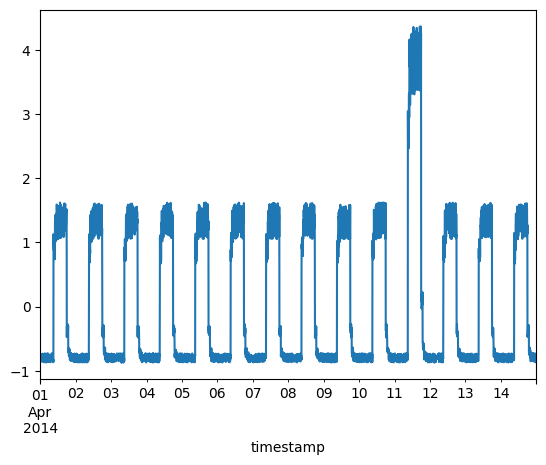

In [46]:
df_test_value.plot(legend=False)

In [47]:
X_test = create_sequences(df_test_value.values)
X_test.shape

(3745, 288, 1)

In [48]:
X_test_pred = model.predict(X_test)
test_mae = np.mean(np.abs(X_test - X_test_pred), axis=1)
test_mae.shape

118/118 [==============================] - 0s 3ms/step


(3745, 1)

Text(0, 0.5, 'Nnumber of samples')

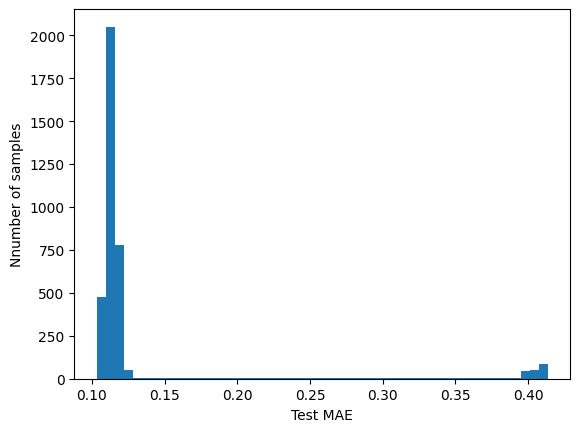

In [53]:
plt.hist(test_mae, bins=50)
plt.xlabel('Test MAE')
plt.ylabel('Nnumber of samples')

In [62]:
anomalies = test_mae > threshold
print(f'number of anomalies: {np.sum(anomalies)}') 
print(f'indices: {np.where(anomalies)}')

number of anomalies: 418
indices: (array([ 970, 1646, 1650, 1652, 1653, 1654, 1658, 1659, 1662, 1674, 1682,
       1690, 1694, 1702, 1830, 1834, 2517, 2523, 2527, 2687, 2691, 2695,
       2697, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710,
       2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721,
       2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732,
       2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743,
       2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754,
       2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765,
       2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776,
       2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787,
       2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798,
       2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809,
       2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820,
       2821, 282

In [63]:
index = 2754
np.all(anomalies[index:(2754 + TIME_STEPS)])

True

In [65]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[(data_idx - TIME_STEPS + 1):data_idx]):
        anomalous_data_indices.append(data_idx)
print(anomalous_data_indices)

[2988, 2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, 3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096]


In [67]:
df_daily_jumpsup.shape

(4032, 1)

<Axes: xlabel='timestamp'>

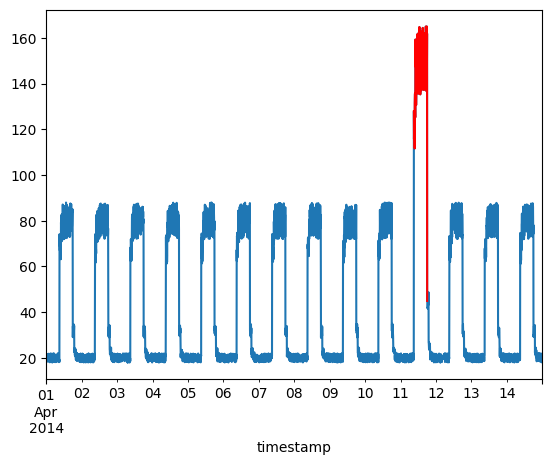

In [69]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
ax = plt.subplot()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color='r')